# Section 5: Adam Experiment and Example

## Section Overview and Goals

### Objectives
The purpose of this experiment is to analyze and compare the behavior of optimization algorithms in training neural networks. In particular, we focus on the Adam algorithm and contrast its performance with Adadelta under controlled conditions.

### Datasets
- MNIST (handwritten digits)

### Models
- Multilayer Perceptron (MLP) — a simple fully connected architecture
- Convolutional Neural Network (CNN) — a basic convolutional model for image classification

### Procedure:
1. Train each model on the datasets using Adam.
2. Repeat the same experiments using Adadelta with identical initialization and hyperparameters where possible.
3. Record training dynamics at both the iteration level (batch updates) and epoch level.
4. Construct visualizations of loss and accuracy curves to highlight differences in convergence speed, stability, and final performance.

### Goals:
By comparing Adam and Adadelta across the dataset and architectures, we aim to gain insights into:
1. How optimizer choice influences convergence behavior
2. Differences in training stability and generalization
3. Practical considerations when selecting optimizers for image classification tasks

## Experiment: MNIST

Before starting the experiments, we first need to import the datasets and split them into training and testing sets.

For MNIST, the dataset is conveniently available through the PyTorch torchvision library, which provides built-in utilities for downloading, transforming, and loading image data.

To prepare the data, we define a custom transformation pipeline using torchvision.transforms.Compose. In this case, the pipeline includes a single step:

- transforms.ToTensor()

    1. Converts each image from a PIL format (or NumPy array) into a PyTorch tensor.

    2. Rearranges the image dimensions from (H, W, C) to (C, H, W), which is the format expected by PyTorch models.

    3. Scales pixel values from integers in the range [0, 255] to floating-point numbers in the normalized range [0.0, 1.0].

Since the features in MNIST are simply the pixel intensities of the images, this transformation ensures that the data is in the correct format and scale for training neural networks.

In [34]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_train_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=False
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=False
)

Next we will construct the data loaders with the batch size = 64.

In [35]:
import torch
batch_size = 64
from torch.utils.data import DataLoader
torch.manual_seed(59)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
device = torch.device("cuda:0")

### Multilayer Perceptron

Next, we build the Multilayer Perceptron (MLP) architecture that will be used for classification.

- Input Layer: Since MNIST images are 28×28 pixels, we first flatten each image into a 784-dimensional vector.

- Hidden Layers:

    1. First hidden layer: 64 neurons

    2. Second hidden layer: 32 neurons

    3. Third hidden layer: 16 neurons

- Each hidden layer uses the ReLU activation function to introduce non-linearity and help the network learn complex patterns.

- Output Layer: A fully connected linear layer with 10 outputs, corresponding to the digit classes 0–9.

In [36]:
from torch import nn
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

def build_mlp(input_size, hidden_units=[64,32,16], output_size=10):
    layers = [nn.Flatten()]
    for unit in hidden_units:
        layers.append(nn.Linear(input_size, unit))
        layers.append(nn.ReLU())
        input_size = unit
    layers.append(nn.Linear(hidden_units[-1], output_size))
    return nn.Sequential(*layers)

adam_mlp_model = build_mlp(input_size)
adadelta_mlp_model = build_mlp(input_size)

adam_mlp_model = adam_mlp_model.to(device)
adadelta_mlp_model = adadelta_mlp_model.to(device)

Since MNIST is a classic dataset for multiclass classification, where each image must be classified into one of 10 possible digit classes (0–9), the most appropriate loss function for this experiment is nn.CrossEntropyLoss because of the following properties and reasons:
- The model’s final layer produces raw scores (logits) for each of the 10 classes.
- nn.CrossEntropyLoss first applies a softmax operation to convert these logits into probabilities, ensuring they form a valid distribution across classes.
- It then computes the negative log-likelihood of the probability assigned to the true class.
    -   If the model assigns high probability to the correct class → the loss is low.
    -   If the model assigns low probability to the correct class → the loss is high.
We will use a learning rate of 0.001, which is widely considered a reliable default for many deep learning models.

In [37]:
loss_fn = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(adam_mlp_model.parameters(), lr=0.001)
adadelta_optimizer = torch.optim.Adadelta(adadelta_mlp_model.parameters())

We now move on to the training, testing, and visualization stages of the experiment.
- Training: The models will be trained for 20 epochs, which is generally sufficient for MNIST to achieve high accuracy while avoiding overfitting.
- Visualization: During training, we will track and visualize the loss function to monitor learning progress. Specifically, Loss improvement will be plotted after each epoch to show overall convergence. Loss will also be recorded after each batch to capture finer-grained fluctuations and provide deeper insight into the optimization process.

In [38]:
import matplotlib.pyplot as plt
torch.manual_seed(43)
num_epochs = 20
batch_losses_adam = []
batch_losses_adadelta = []
epoch_accs_adam = []
epoch_accs_adadelta = []
for epoch in range(num_epochs):
    correct_adam = 0
    correct_adadelta = 0
    total = 0
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device)
        adam_pred = adam_mlp_model(x_batch)
        adadelta_pred = adadelta_mlp_model(x_batch)

        adam_loss = loss_fn(adam_pred, y_batch)
        adadelta_loss = loss_fn(adadelta_pred, y_batch)

        adam_loss.backward()
        adadelta_loss.backward()
        
        adam_optimizer.step()
        adadelta_optimizer.step()

        adam_optimizer.zero_grad()
        adadelta_optimizer.zero_grad()


        batch_losses_adam.append(adam_loss.item())
        batch_losses_adadelta.append(adadelta_loss.item())
        
        adam_correct_batch = (torch.argmax(adam_pred, dim=1) == y_batch).sum().item()
        adadelta_correct_batch = (torch.argmax(adadelta_pred, dim=1) == y_batch).sum().item()

        correct_adam += adam_correct_batch
        correct_adadelta += adadelta_correct_batch

        total += y_batch.size(0)

    epoch_accs_adam.append(correct_adam / total)
    epoch_accs_adadelta.append(correct_adadelta / total)
    print(f"Epoch {epoch+1}: Adam Acc={epoch_accs_adam[-1]:.4f}, Adadelta Acc={epoch_accs_adadelta[-1]:.4f}")

# save the model
adam_mlp_path = 'adam_mnist_MLP.pt'
adadelta_mlp_path = 'adadelta_mnist_MLP.pt'
torch.save(adam_mlp_model, adam_mlp_path)
torch.save(adadelta_mlp_model, adadelta_mlp_path)

Epoch 1: Adam Acc=0.8530, Adadelta Acc=0.8753
Epoch 2: Adam Acc=0.9388, Adadelta Acc=0.9587
Epoch 3: Adam Acc=0.9559, Adadelta Acc=0.9695
Epoch 4: Adam Acc=0.9640, Adadelta Acc=0.9751
Epoch 5: Adam Acc=0.9693, Adadelta Acc=0.9789
Epoch 6: Adam Acc=0.9741, Adadelta Acc=0.9815
Epoch 7: Adam Acc=0.9762, Adadelta Acc=0.9836
Epoch 8: Adam Acc=0.9795, Adadelta Acc=0.9857
Epoch 9: Adam Acc=0.9819, Adadelta Acc=0.9872
Epoch 10: Adam Acc=0.9836, Adadelta Acc=0.9884
Epoch 11: Adam Acc=0.9850, Adadelta Acc=0.9898
Epoch 12: Adam Acc=0.9867, Adadelta Acc=0.9909
Epoch 13: Adam Acc=0.9880, Adadelta Acc=0.9919
Epoch 14: Adam Acc=0.9899, Adadelta Acc=0.9925
Epoch 15: Adam Acc=0.9898, Adadelta Acc=0.9935
Epoch 16: Adam Acc=0.9914, Adadelta Acc=0.9943
Epoch 17: Adam Acc=0.9909, Adadelta Acc=0.9948
Epoch 18: Adam Acc=0.9927, Adadelta Acc=0.9952
Epoch 19: Adam Acc=0.9932, Adadelta Acc=0.9959
Epoch 20: Adam Acc=0.9933, Adadelta Acc=0.9962


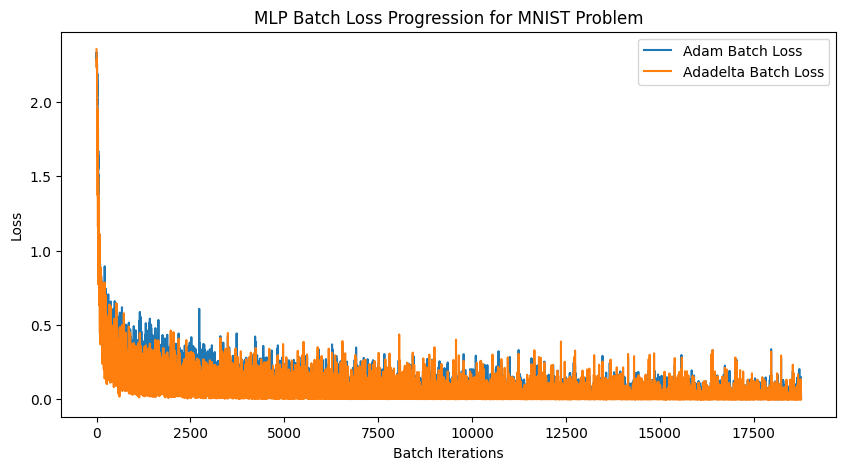

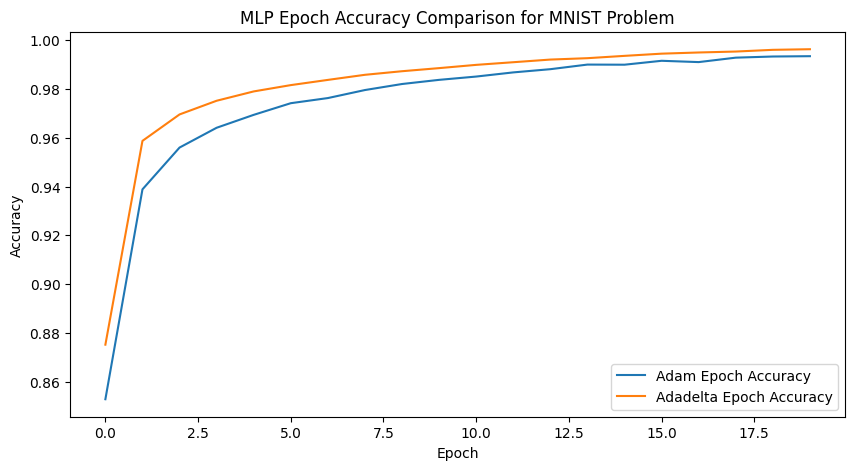

In [39]:
plt.figure(figsize=(10,5))
plt.plot(batch_losses_adam, label="Adam Batch Loss")
plt.plot(batch_losses_adadelta, label="Adadelta Batch Loss")
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.title("MLP Batch Loss Progression for MNIST Problem")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epoch_accs_adam, label="Adam Epoch Accuracy")
plt.plot(epoch_accs_adadelta, label="Adadelta Epoch Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Epoch Accuracy Comparison for MNIST Problem")
plt.legend()
plt.show()

In [40]:
adam_mnist_MLP = torch.load(adam_mlp_path, weights_only=False)
adadelta_mnist_MLP = torch.load(adadelta_mlp_path, weights_only=False)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            correct += (torch.argmax(preds, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=True)
adam_acc = evaluate(adam_mnist_MLP, test_dl)
adadelta_acc = evaluate(adadelta_mnist_MLP, test_dl)

print(f"MLP with Adam optimizer test accuracy: {adam_acc:.4f}")
print(f"MLP with Adadelta optimizer test accuracy: {adadelta_acc:.4f}")

MLP with Adam optimizer test accuracy: 0.9716
MLP with Adadelta optimizer test accuracy: 0.9769


## Convolutional neural network

For the CNN architecture, we will construct a standard two‑block convolutional network, which is widely used for simple image classification tasks such as MNIST.
- First convolutional block: Responsible for learning low‑level features such as edges, corners, and simple textures. These are the basic building blocks of digit shapes.
- Second convolutional block: Focuses on higher‑level features like strokes, curves, and digit parts, enabling the network to capture more abstract representations.
- Fully connected layers: After flattening the feature maps, the dense layers act as a classifier. They take the learned feature representations from the convolutional blocks and progressively reduce them through hidden units, applying non‑linear activations and dropout for regularization. The final linear layer outputs logits for the 10 digit classes (0–9), enabling the network to make its predictions.

In [41]:
def build_cnn(image_size, output_size=10, in_channels=1, hidden_units=1024, dropout_p=0.5):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten()
    ]
    
    dummy_input = torch.zeros(1, in_channels, image_size, image_size)
    flatten_size = nn.Sequential(*layers)(dummy_input).shape[1]
    
    fc_layers = [
        nn.Linear(flatten_size, hidden_units),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(hidden_units, output_size)
    ]
    
    return nn.Sequential(*(layers + fc_layers))



adam_cnn_model = build_cnn(image_size[1])
adadelta_cnn_model = build_cnn(image_size[1])

adam_cnn_model.to(device)
adadelta_cnn_model.to(device)

adam_optimizer = torch.optim.Adam(adam_cnn_model.parameters(), lr=0.001)
adadelta_optimizer = torch.optim.Adadelta(adadelta_cnn_model.parameters())

For the next phase, we will repeat the experiment using a Convolutional Neural Network (CNN). Since CNNs are specifically designed for image data, they are generally more effective at capturing spatial features and patterns compared to fully connected MLPs. Therefore, we expect both optimizers (Adam and Adadelta) to achieve better performance on the MNIST classification task. The overall experimental setup including training epochs, loss function, and evaluation procedure will remain consistent with the MLP experiment, allowing us to make a clear comparison between the two architectures.

In [42]:
num_epochs = 20
batch_losses_adam = []
batch_losses_adadelta = []
epoch_accs_adam = []
epoch_accs_adadelta = []
for epoch in range(num_epochs):
    correct_adam = 0
    correct_adadelta = 0
    total = 0
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device)
        
        adam_pred = adam_cnn_model(x_batch)
        adadelta_pred = adadelta_cnn_model(x_batch)

        adam_loss = loss_fn(adam_pred, y_batch)
        adadelta_loss = loss_fn(adadelta_pred, y_batch)

        adam_loss.backward()
        adadelta_loss.backward()
        
        adam_optimizer.step()
        adadelta_optimizer.step()

        adam_optimizer.zero_grad()
        adadelta_optimizer.zero_grad()


        batch_losses_adam.append(adam_loss.item())
        batch_losses_adadelta.append(adadelta_loss.item())
        
        adam_correct_batch = (torch.argmax(adam_pred, dim=1) == y_batch).sum().item()
        adadelta_correct_batch = (torch.argmax(adadelta_pred, dim=1) == y_batch).sum().item()

        correct_adam += adam_correct_batch
        correct_adadelta += adadelta_correct_batch

        total += y_batch.size(0)

    epoch_accs_adam.append(correct_adam / total)
    epoch_accs_adadelta.append(correct_adadelta / total)
    print(f"Epoch {epoch+1}: Adam Acc={epoch_accs_adam[-1]:.4f}, Adadelta Acc={epoch_accs_adadelta[-1]:.4f}")

adam_cnn_path = 'adam_mnist_CNN.pt'
adadelta_cnn_path = 'adadelta_mnist_CNN.pt'
torch.save(adam_cnn_model, adam_cnn_path)
torch.save(adadelta_cnn_model, adadelta_cnn_path)

Epoch 1: Adam Acc=0.9450, Adadelta Acc=0.9458
Epoch 2: Adam Acc=0.9824, Adadelta Acc=0.9852
Epoch 3: Adam Acc=0.9868, Adadelta Acc=0.9895
Epoch 4: Adam Acc=0.9900, Adadelta Acc=0.9923
Epoch 5: Adam Acc=0.9922, Adadelta Acc=0.9938
Epoch 6: Adam Acc=0.9934, Adadelta Acc=0.9947
Epoch 7: Adam Acc=0.9944, Adadelta Acc=0.9961
Epoch 8: Adam Acc=0.9952, Adadelta Acc=0.9962
Epoch 9: Adam Acc=0.9959, Adadelta Acc=0.9971
Epoch 10: Adam Acc=0.9963, Adadelta Acc=0.9976
Epoch 11: Adam Acc=0.9968, Adadelta Acc=0.9981
Epoch 12: Adam Acc=0.9970, Adadelta Acc=0.9980
Epoch 13: Adam Acc=0.9977, Adadelta Acc=0.9981
Epoch 14: Adam Acc=0.9973, Adadelta Acc=0.9984
Epoch 15: Adam Acc=0.9977, Adadelta Acc=0.9988
Epoch 16: Adam Acc=0.9981, Adadelta Acc=0.9989
Epoch 17: Adam Acc=0.9983, Adadelta Acc=0.9990
Epoch 18: Adam Acc=0.9984, Adadelta Acc=0.9991
Epoch 19: Adam Acc=0.9979, Adadelta Acc=0.9994
Epoch 20: Adam Acc=0.9980, Adadelta Acc=0.9993


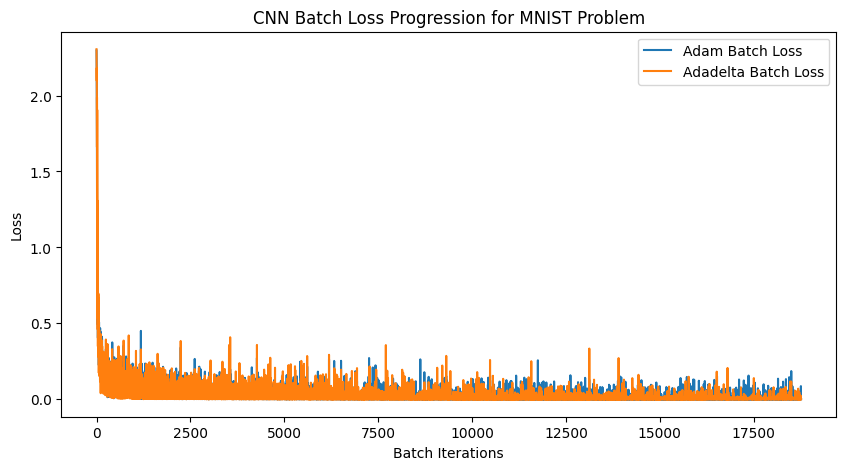

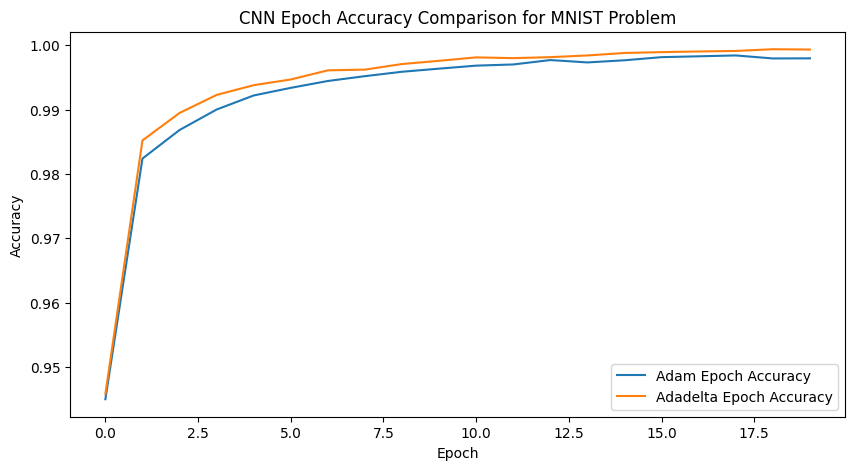

In [43]:
plt.figure(figsize=(10,5))
plt.plot(batch_losses_adam, label="Adam Batch Loss")
plt.plot(batch_losses_adadelta, label="Adadelta Batch Loss")
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.title("CNN Batch Loss Progression for MNIST Problem")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epoch_accs_adam, label="Adam Epoch Accuracy")
plt.plot(epoch_accs_adadelta, label="Adadelta Epoch Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Epoch Accuracy Comparison for MNIST Problem")
plt.legend()
plt.show()

In [44]:
adam_mnist_CNN = torch.load(adam_cnn_path, weights_only=False)
adadelta_mnist_CNN = torch.load(adadelta_cnn_path, weights_only=False)

test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=True)
adam_acc = evaluate(adam_mnist_CNN, test_dl)
adadelta_acc = evaluate(adadelta_mnist_CNN, test_dl)

print(f"CNN with Adam optimizer test accuracy: {adam_acc:.4f}")
print(f"CNN with Adadelta optimizer test accuracy: {adadelta_acc:.4f}")

CNN with Adam optimizer test accuracy: 0.9926
CNN with Adadelta optimizer test accuracy: 0.9939


## Conclusion
After extensive training and evaluation on the MNIST dataset, the results demonstrate that both the Adadelta and Adam optimizers achieve strong and competitive performance. While Adadelta shows a slight advantage over Adam in terms of accuracy, both optimizers effectively facilitate model convergence and consistently yield high classification performance. This indicates that either optimizer can be considered a reliable choice for training neural networks on MNIST, with Adadelta offering a marginal edge in overall effectiveness